# Feasibility test of the self-learning Near-limit Kinetic Energy Harvesting control system.

This code is created as part of "Near-Limit Kinetic Energy Harvesting from Arbitrary Acceleration Waveforms: Feasibility Study by the Example of Human Motion" 
paper. 

## 1. Import of the analysable data

In [1]:
import data_processing as dp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Reading the sample:

In [2]:
#Reading of the .csv dataset
[t,ax,ay,az,a] = dp.reading_acc_data('Data/walking_right_hand/walking_right_hand_2.csv')
#Removing of the duplicating data-points:
[t,ax,ay,az,a] = dp.clerification([t,ax,ay,az,a])
#Interpolating the missing time-points to have the regulare time-step:
[t,ax,ay,az,a,dt] = dp.normalization([t,ax,ay,az,a])
#Cutting the edges of investigating time-series:
t = t[1800:]
ax = ax[1800:]

Assuming that we have placed the harvester along x-axis. Firdt check how the data-set looks-like:

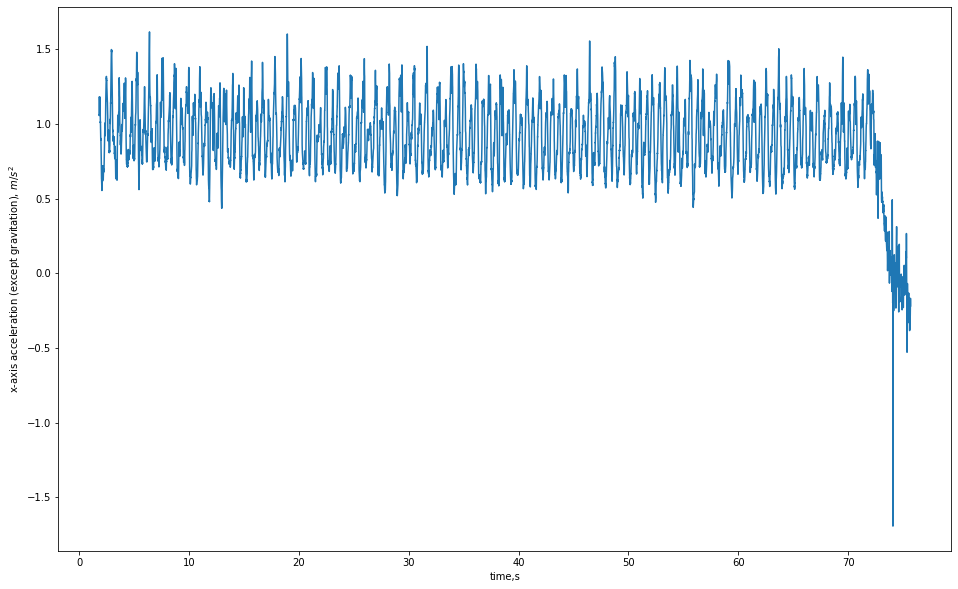

In [3]:
fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (16,10))
plt.plot(t,ax)
plt.xlabel('time,s')
plt.ylabel('x-axis acceleration (except gravitation), $m/s^2$')
plt.show()

## 2. Fast Fourier Transform to understand how to down-sample the signal.

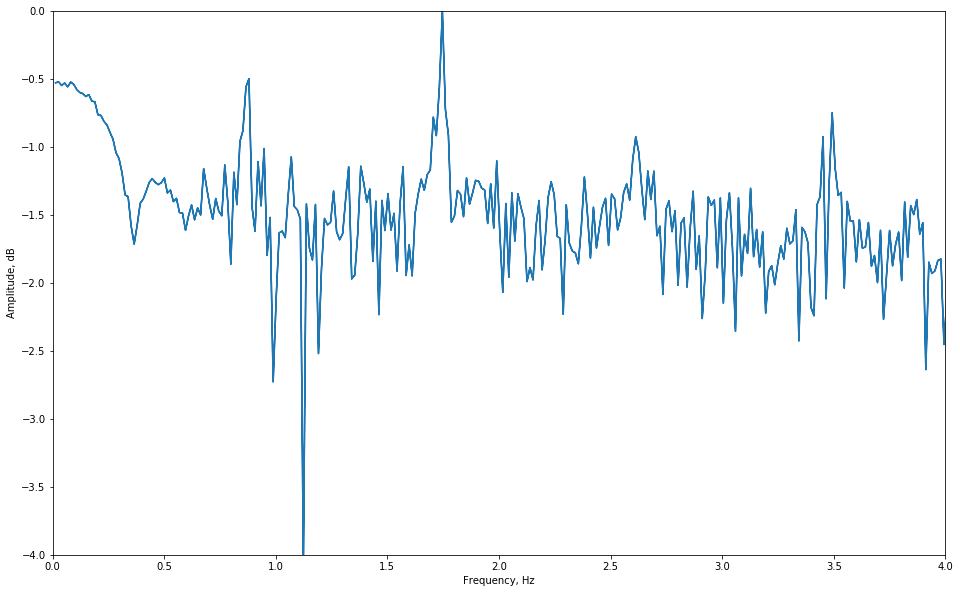

In [4]:
fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (16,10))
fft_signal = np.abs(np.fft.fft(ax))
fft_freq = np.abs(np.fft.fftfreq(len(t)) / dt)
plt.plot(fft_freq[1:], np.log10(fft_signal[1:]/max(fft_signal[1:])))
plt.xlim(0,4)
plt.ylim(-4,0)
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude, dB')
plt.show()

### a) Define the Sampling time

In [5]:
fft_signal_db = np.log10(fft_signal[1:]/max(fft_signal[1:]))
fft_max_i = np.where(fft_signal_db == max(fft_signal_db))
#Sampling frequancy:
fft_freq[fft_max_i[0][0]]
#Sampling time:
t_sampl = 1.0/fft_freq[fft_max_i[0][0]]
print('Sampling time is '+str(round(t_sampl,4))+' s')

Sampling time is 0.5682 s


### b) Define the initial phase of the oscillations and correnting the sampling time

In [6]:
i_sampl = 2*int(t_sampl/dt) +2
print('Sampling index: '+str(i_sampl))
n_sampl = int(len(t)/(2*i_sampl))
print('Number of samples: '+str(n_sampl))

Sampling index: 1138
Number of samples: 32


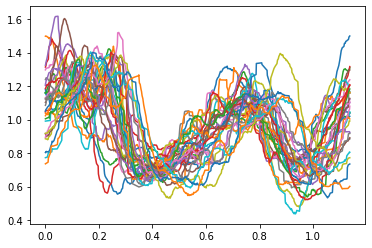

In [7]:
for i in range(0,32):
    plt.plot(np.array(t[i_sampl*i:i_sampl*(i+1)])-t[i_sampl*i], ax[i_sampl*i:i_sampl*(i+1)])

### c) Sampling of the dataset

In [8]:
data_samples = dict({})
for i in range(n_sampl):
    data_samples[i] = {'time':np.array(t[i_sampl*i:i_sampl*(i+1)])-t[i_sampl*i], 'ax':ax[i_sampl*i:i_sampl*(i+1)]}

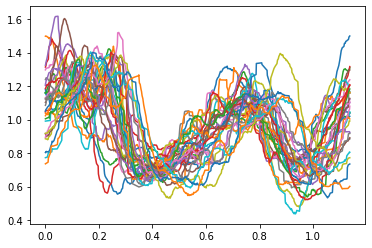

In [9]:
for i in range(n_sampl):
    plt.plot(data_samples[i]['time'],data_samples[i]['ax'])
plt.show()

## 3. Finding the local extrema of each subset

In [10]:
def getLocalExtrema(time, accel):
    '''
    This function is searching for all pairs of local maximum-minimum in the time-acceleration sequence
    It returns the list of lists:
    amaxs - list of acceleration- maximums
    tmaxs - list of corresponding times
    imaxs - list of corresponding order-indexes
    amins - list of acceleration- minimums
    tmins - list of corresponding times
    imins - list of corresponding order-indexes    
    '''
    amaxs = []
    tmaxs = []
    imaxs = []
    amins = []
    tmins = []
    imins = []
    
    ifmax = False
    
    if(accel[0]>accel[1]):
        amaxs.append(accel[0])
        tmaxs.append(time[0])
        imaxs.append(0)
        ifmax = True
        
    for i in range(1,(len(accel)-1)):
        if(((accel[i]>=accel[i-1])&(accel[i]>=accel[i+1]))&(not ifmax)&(i not in imaxs)&(i not in imins)):
            amaxs.append(accel[i])
            tmaxs.append(time[i])
            imaxs.append(i)
            ifmax = True

        elif(((accel[i]<=accel[i-1])&(accel[i]<=accel[i+1]))&(ifmax)&(i not in imaxs)&(i not in imins)):
            amins.append(accel[i])
            tmins.append(time[i])
            imins.append(i)
            ifmax = False
    
    if(ifmax):
        amins.append(accel[-1])
        tmins.append(time[-1])
        imins.append(len(accel)-1)
        
    return([amaxs,tmaxs,imaxs,amins,tmins,imins])

Here we are looking for all maxima-minima pairs in our data-set:

In [11]:
for i in range(n_sampl):
    [amaxs,tmaxs,imaxs,amins,tmins,imins] = getLocalExtrema(data_samples[i]['time'], data_samples[i]['ax'])
    data_samples[i]['amaxs'] = amaxs
    data_samples[i]['tmaxs'] = tmaxs
    data_samples[i]['imaxs'] = imaxs
    data_samples[i]['amins'] = amins
    data_samples[i]['tmins'] = tmins
    data_samples[i]['imins'] = imins

Visualization of first 5 sub-sets: with minimums and maximums:

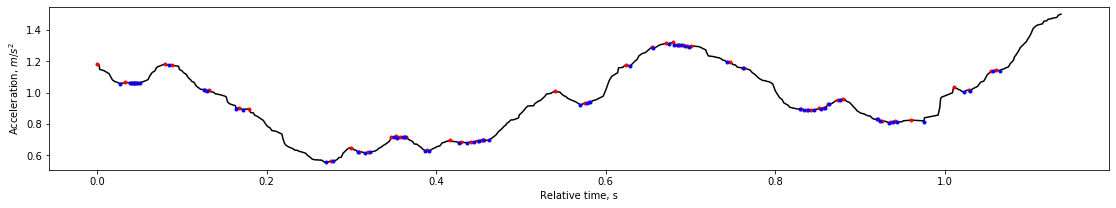

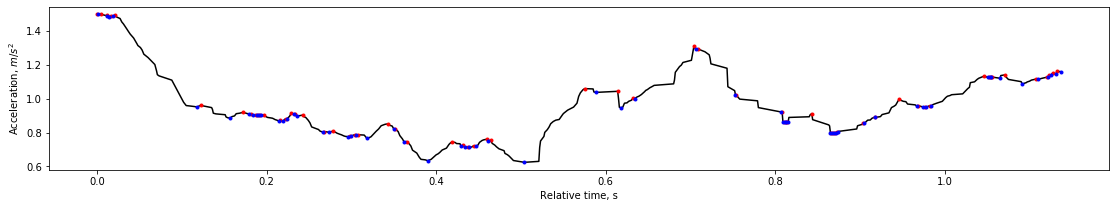

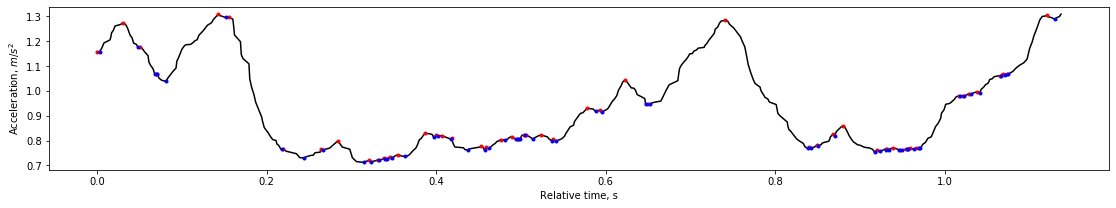

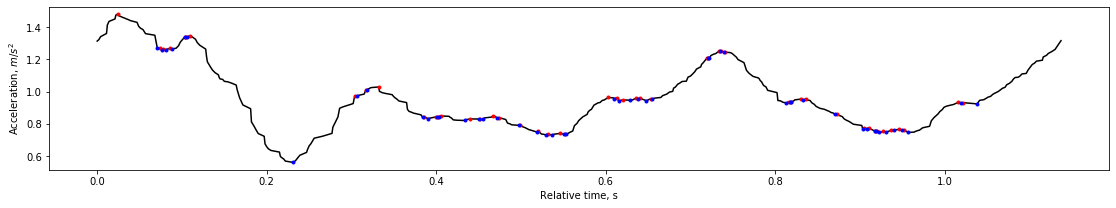

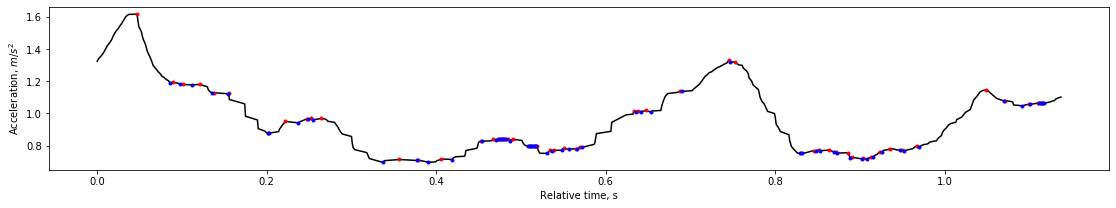

In [12]:
for i in range(5):
    fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (19,3))
    plt.plot(data_samples[i]['time'],data_samples[i]['ax'],color='black')
    plt.plot(data_samples[i]['tmaxs'],data_samples[i]['amaxs'],'.',color = 'red')
    plt.plot(data_samples[i]['tmins'],data_samples[i]['amins'],'.',color = 'blue')
    plt.xlabel('Relative time, s')
    plt.ylabel('Acceleration, $m/s^2$')
    plt.show()

Next function marks maximum-minimum pairs in order to get the maximal ammount of energy, and returnes *n* best pairs. *Note that this is very primitive benchmark, because it includes only the **neighbor** ninimum-maximum pairs. Globally, there is always more optimal ways, including very non-trivial optimization*.  

In [13]:
def def_optimal_min_max(tmin, tmax, axmin, axmax, imins, imaxs, n):
    '''
    tmin, tmax, axmin, axmax, imin, imax - output of getLocalExtrema function
    n - number of the best maximum-minimum pairs    
    '''
    max_min_a = []
    max_min_t = []
    for i in range(len(tmin)):
        max_min_t.append((tmin[i]-tmax[i]))
        max_min_a.append((axmax[i]-axmin[i]))
    
    temp_max_min_a = max_min_a.copy()
    temp_max_min_a.sort()
    
    sorted_imins = []
    sorted_imaxs = []
    sorted_tmins = []
    sorted_tmaxs = []
    sorted_amins = []
    sorted_amaxs = []
    
    for mm in temp_max_min_a[::-1]:
        if(mm>0):
            i = max_min_a.index(mm)
            sorted_imins.append(imins[i])
            sorted_imaxs.append(imaxs[i])
            sorted_tmins.append(tmin[i])
            sorted_tmaxs.append(tmax[i])
            sorted_amins.append(axmin[i])
            sorted_amaxs.append(axmax[i])
    
    if(n>len(sorted_imins)):
        n = len(sorted_imins)
    
    sorted_imins = sorted_imins[:n]
    sorted_imaxs = sorted_imaxs[:n]
    sorted_tmins = sorted_tmins[:n]
    sorted_tmaxs = sorted_tmaxs[:n]
    sorted_amins = sorted_amins[:n]
    sorted_amaxs = sorted_amaxs[:n]
    
    W = 0
    for i in range(len(sorted_amins)):
        W += sorted_amaxs[i]-sorted_amins[i]
    
    return(sorted_tmins, sorted_tmaxs, sorted_amins, sorted_amaxs, sorted_imins, sorted_imaxs, W)

Visualization of the way how algirithm works:

0


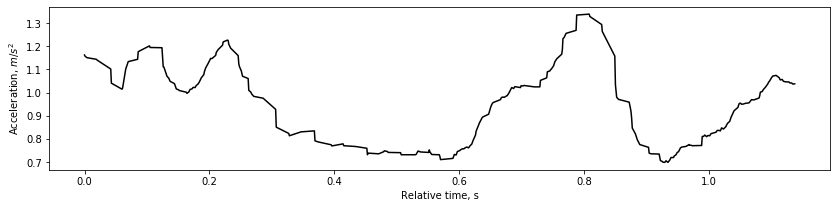

0.6400000000001045


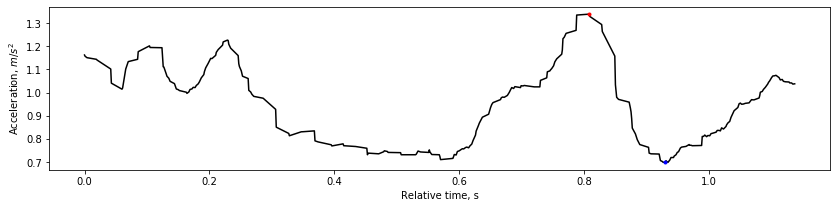

1.0530000000001456


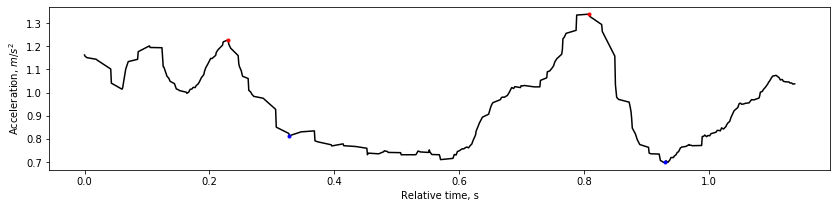

1.2580000000000728


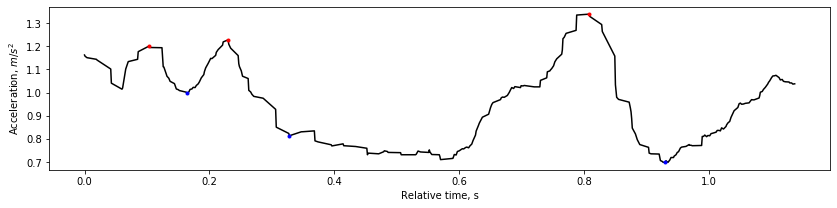

1.4055000000005426


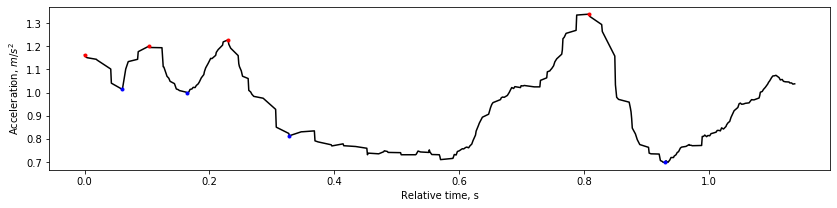

In [14]:
# number of investigating sub-set
i = 10
for n in range(5):
    mit,mat,mia,maa,mii,mai,W = def_optimal_min_max(data_samples[i]['tmins'],data_samples[i]['tmaxs'],data_samples[i]['amins'],data_samples[i]['amaxs'],data_samples[i]['imins'],data_samples[i]['imaxs'],n)
    print(W)
    fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (14,3))
    plt.plot(data_samples[i]['time'],data_samples[i]['ax'],color='black')
    plt.plot(mit,mia,'.',color='blue')
    plt.plot(mat,maa,'.',color='red')
    plt.xlabel('Relative time, s')
    plt.ylabel('Acceleration, $m/s^2$')
    plt.show()

In [15]:
nmax = 40
effic = dict({})
for i in range(len(data_samples)):
    Ws = dict({})
    for n in range(nmax):
        mit,mat,mia,maa,mii,mai,W1 = def_optimal_min_max(data_samples[i]['tmins'],data_samples[i]['tmaxs'],data_samples[i]['amins'],data_samples[i]['amaxs'],data_samples[i]['imins'],data_samples[i]['imaxs'],n)
        mit,mat,mia,maa,mii,mai,W2 = def_optimal_min_max(data_samples[i]['tmins'],data_samples[i]['tmaxs'],data_samples[i]['amins'],data_samples[i]['amaxs'],data_samples[i]['imins'],data_samples[i]['imaxs'],100)
        Ws[n] = W1/W2
    effic[i] = Ws
    
losses = dict({})
dl = 0.03
for n in range(nmax):
    losses[n] = n*dl

Looking on the energy income and loses:

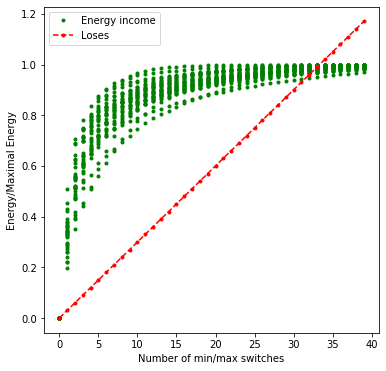

In [16]:
fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6))
for i in range(len(data_samples)-1):
    plt.plot(list(effic[i].keys()),list(effic[i].values()),'.',color = 'green')
plt.plot(list(effic[len(data_samples)-1].keys()),list(effic[len(data_samples)-1].values()),'.',color = 'green', label = 'Energy income')
plt.plot(list(losses.keys()),list(losses.values()),'.--',color = 'red', label = 'Loses')
plt.legend()
plt.xlabel('Number of min/max switches')
plt.ylabel('Energy/Maximal Energy')
plt.savefig('optimal.svg')
plt.show()

In [17]:
nmax = 40
effic_with_loses = dict({})
error_with_loses = dict({})
for n in range(nmax):
    average_W = 0
    std_W = 0
    for i in range(len(data_samples)):
        average_W += effic[i][n]
    average_W = average_W/len(data_samples)
    for i in range(len(data_samples)):
        std_W += (effic[i][n]-average_W)**2
        
    effic_with_loses[n] = average_W - losses[n]
    error_with_loses[n] = 2.75*(std_W/(len(data_samples)*(len(data_samples)-1)))**0.5

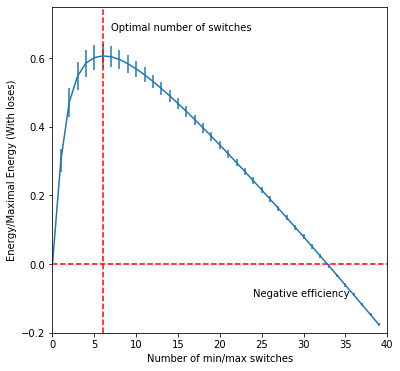

In [18]:
fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6))
plt.errorbar(list(effic_with_loses.keys()),list(effic_with_loses.values()),yerr = list(error_with_loses.values()))
plt.plot([0,40],[0,0],'r--')
plt.annotate('Negative efficiency',xy=(0.6,0.11),xycoords = 'axes fraction')
plt.annotate('Optimal number of switches',xy=(7,0.68),xycoords = 'data')
noptim = 6
plt.plot([noptim,noptim],[-0.2,0.75],'r--')
plt.ylim([-0.2,0.75])
plt.xlim([0,40])
plt.xlabel('Number of min/max switches')
plt.ylabel('Energy/Maximal Energy (With loses)')
plt.savefig('optimal_with_loses.svg')
plt.show()

Now, we know the optimal number of minimums and maximums for a given loses-function. 

In [19]:
def experiment_emulation(n_max):
    eff = []
    eff2 = []
    i = 0
    nswitches = 0
    a_samples = []
    t_samples = []

    while(i<len(data_samples)):
        a_aver = []
        t_aver = []
        for j in range(len(data_samples[i]['ax'])):
            aa = 0
            at = 0
            for k in range(len(a_samples)):
                aa+=a_samples[k][j]
                at+=t_samples[k][j]
            a_aver.append(aa)
            t_aver.append(at)

        [amaxs1,tmaxs1,imaxs1,amins1,tmins1,imins1] = getLocalExtrema(data_samples[i]['time'], data_samples[i]['ax'])
        [amaxs2,tmaxs2,imaxs2,amins2,tmins2,imins2] = getLocalExtrema(t_aver, a_aver)
        mit1,mat1,mia1,maa1,mii1,mai1,W1 = def_optimal_min_max(tmins1,tmaxs1,amins1,amaxs1,imins1,imaxs1,6)
        mit2,mat2,mia2,maa2,mii2,mai2,W2 = def_optimal_min_max(tmins2,tmaxs2,amins2,amaxs2,imins2,imaxs2,6)
        mit3,mat3,mia3,maa3,mii3,mai3,W_max = def_optimal_min_max(tmins1,tmaxs1,amins1,amaxs1,imins1,imaxs1,100)
        
        W_given = 0
        for j in range(len(mii2)):
            W_given += data_samples[i]['ax'][mai2[j]] - data_samples[i]['ax'][mii2[j]]
        
        a_samples.append(data_samples[i]['ax'])
        t_samples.append(data_samples[i]['time'])

        
        if(len(a_samples)>n):
            a_samples = a_samples[1:]
            a_samples = a_samples[1:]

        eff.append(W_given/W_max)
        eff2.append(W1/W_max)
        i+=1
    return(eff,eff2)

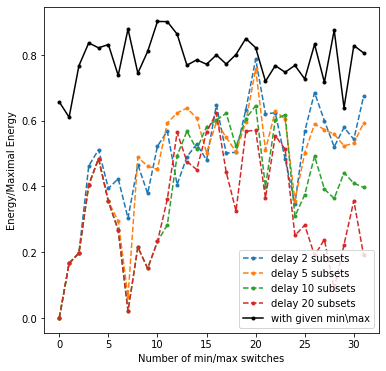

In [20]:
fig,axs = plt.subplots(ncols = 1, nrows = 1, figsize = (6,6))
for n in [2,5,10,20]:
    eff,eff2 = experiment_emulation(n)
    plt.plot(eff,'.--',label = 'delay '+str(n)+' subsets')
plt.plot(eff2,'k.-',label = 'with given min\max')
plt.xlabel('Number of min/max switches')
plt.ylabel('Energy/Maximal Energy')
plt.legend()
plt.savefig('algorithm_emulation.svg')
plt.show()

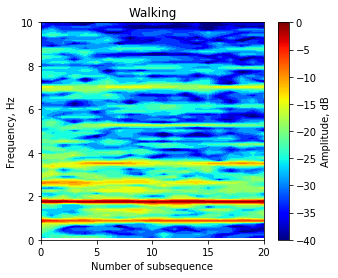

In [21]:
from mpl_toolkits import mplot3d
from matplotlib import cm

fft = []
fftfreq = []
growing_sample = []

pp = []
ff = []
tt = []

for i in range(int(len(data_samples))-7):
    growing_sample=data_samples[i]['ax']+data_samples[i+1]['ax']+data_samples[i+2]['ax']+data_samples[i+3]['ax']+data_samples[i+4]['ax']+data_samples[i+5]['ax']+data_samples[i+6]['ax']
    N = int(0.5*len(growing_sample))
    a = np.abs(np.fft.fft(growing_sample))
    f = 1e3*np.fft.fftfreq(2*N)
    fft.append(a)
    fftfreq.append(f)
    ff.append(f[1:N])
    tt.append(i*np.ones(N-1))
    pp.append(20*np.log10(a[1:N]/np.max(a[1:N])))
fig, ax = plt.subplots(figsize=(5,4))
cf = plt.contourf(tt,ff,pp,levels = 64, cmap = cm.jet, vmin = -40, vmax = 0)
m = plt.cm.ScalarMappable(cmap=cm.jet)
m.set_array(pp)
m.set_clim(-40., 0.)
cb = plt.colorbar(m)
cb.ax.set_ylabel('Amplitude, dB')
plt.ylim((0,10))
plt.xlim((0,20))
plt.xlabel('Number of subsequence')
plt.ylabel('Frequency, Hz')
plt.title('Walking')
plt.savefig('walking_fft.png')
plt.show()

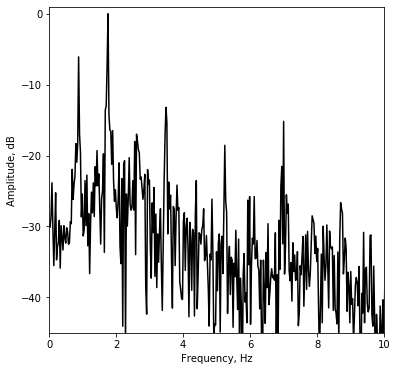

In [47]:
tot = []
for i in range(len(data_samples)):
    tot+=data_samples[i]['ax']

N = int(0.5*len(tot))
a = np.abs(np.fft.fft(tot))
f = 1e3*np.fft.fftfreq(2*N)
fig,axs = plt.subplots(figsize=(6,6))
plt.plot(f[1:N],20*np.log10(a[1:N]/np.max(a[1:N])),'k-')
plt.xlim((0,10))
plt.ylim((-45,1))
plt.xlabel('Frequency, Hz')
plt.ylabel('Amplitude, dB')
plt.savefig('ampl.svg')
plt.show()